In [1]:
!conda install boto3 pandas -y

Solving environment: done

# All requested packages already installed.



In [2]:
import boto3
import os
import pandas as pd
from dateutil.parser import parse
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
MYREGION="us-east-1"
MYBUCKET='summit-game-records'
s3 = boto3.client('s3', region_name=MYREGION,
                   aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
                   aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY'])
#print(len(s3.list_objects_v2(Bucket=MYBUCKET)))

In [4]:
def isAIThere(ddict):
    if "isAi" in ddict['winner'] or "isAi" in ddict['loser']:
        return True
    else:
        return False

def isAIWinner(ddict):
    if isAIThere(ddict):
        return ddict['winner']["isAi"]
    else:
        return None

In [5]:
def get_ship_placement_matrix(pdframe, winner_loser):
    bProbs = [[0 for x in range(5)] for x in range(5)]
    for index, row in pdframe.iterrows():
        board = row[winner_loser]
        board = str(board).strip("'<>() ").replace('\'', '\"')
        board = str(board).replace('True', 'true')
        board = str(board).replace('False', 'false')
        board = json.loads(board)
        board1 = board["positions"]
        for k in board1:
            for p in board1[k]['cells']:
                pos = p["origin"]
                bProbs[pos[0]][pos[1]]+=1

    mat = np.array(bProbs)
    max_val = np.amax(mat)
    mat = (mat/max_val)
    mat = mat.transpose()
    return mat

In [6]:
keys = []
resp = s3.list_objects_v2(Bucket=MYBUCKET)

for obj in resp['Contents']:
    keyy = obj['Key']
    if keyy == 'test.txt':
        continue
    keyyy = keyy.split(".json")[0]
    keyyyy = parse(keyyy)
    obj['Key'] = keyyy
    keys.append(obj['Key'])

# print(len(keys))
prefix_df = []
for x in keys:
    if x == "test.txt":
        print(x)
        continue
    obj = s3.get_object(
        Bucket=MYBUCKET,
        Key=x+".json"
    )
    res_json = json.loads(obj['Body'].read().decode("utf-8"))
    prefix_df.append({"date": x, "isAI": isAIWinner(res_json),
                      "winner_board": res_json["winner"]["board"],
                      "winner_attacks": res_json["winner"]["attacks"],
                      "loser_board": res_json["loser"]["board"],
                      "loser_attacks": res_json["loser"]["attacks"],
                      "game": res_json})

In [7]:
df = pd.DataFrame(prefix_df)
df['date'] = pd.to_datetime(df['date'])
mask = (df['date'] > "'2021-04-09'")
df = df.loc[mask]
mask = (df['date'] < "'2021-04-16'")
df = df.loc[mask]
df['date']

412   2021-04-13 17:51:36.652000+00:00
413   2021-04-13 19:33:16.751000+00:00
414   2021-04-14 13:39:21.175000+00:00
415   2021-04-14 13:39:37.740000+00:00
416   2021-04-14 13:41:10.952000+00:00
                    ...               
482   2021-04-15 15:05:19.129000+00:00
483   2021-04-15 15:05:50.916000+00:00
484   2021-04-15 15:10:30.404000+00:00
485   2021-04-15 15:15:09.686000+00:00
486   2021-04-15 15:27:00.591000+00:00
Name: date, Length: 75, dtype: datetime64[ns, UTC]

In [8]:
df.to_csv(index=False, path_or_buf="./s3_exp5.csv")

In [9]:
df = pd.read_csv(filepath_or_buffer='./s3_exp5.csv') 
#print(len(df))

In [10]:
mask1 = (df['isAI'] != None)
df = df.loc[mask1]

ai_won_df = df[df['isAI'] == True]
ai_lost_df = df[df['isAI'] == False]

total = len(df)
won = len(ai_won_df)
lost = len(ai_lost_df)
print("Simulations played: ",total)
print("Simulations AI won: ",won)
print("Simulations AI lost: ",lost)
print("AI win %: ",won*100/total)
print("human win %: ",lost*100/total)

Simulations played:  75
Simulations AI won:  52
Simulations AI lost:  23
AI win %:  69.33333333333333
human win %:  30.666666666666668


[[0.88235294 0.76470588 0.70588235 0.64705882 0.47058824]
 [1.         0.76470588 0.70588235 0.76470588 0.82352941]
 [0.88235294 0.70588235 0.58823529 0.52941176 0.82352941]
 [0.82352941 0.64705882 0.76470588 0.47058824 0.82352941]
 [1.         0.82352941 1.         0.82352941 0.70588235]]


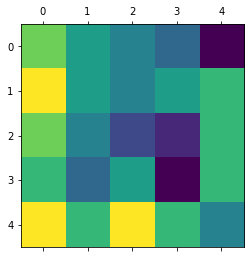

In [11]:
mm = get_ship_placement_matrix(ai_lost_df, "loser_board")
print(mm)
plt.matshow(mm)
plt.show()

[[0.7027027  0.75675676 0.86486486 0.78378378 0.7027027 ]
 [0.75675676 0.83783784 0.91891892 0.78378378 0.67567568]
 [0.75675676 0.67567568 0.91891892 0.83783784 0.75675676]
 [0.86486486 0.7027027  1.         1.         0.62162162]
 [0.89189189 0.59459459 0.86486486 0.72972973 0.67567568]]


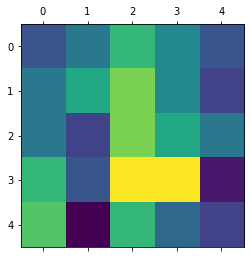

In [12]:
mm = get_ship_placement_matrix(ai_won_df, "winner_board")
print(mm)
plt.matshow(mm)
plt.show()